Regression: consists of predicting a continuous value instead of a discrete label. 
Note: don't confuse regression and the algorithm logistic regression. Confusingly, logistic regression is not a regression algorithm but a classification algorithm. 
dataset: boston housing price dataset / attempt to predict median price of homes in a give Boston suburb in the mid 1970s given: crime rate, property tax rate, etc. / 506 points in total (404 training and 102 testing) also the data points are in different scales (for example the crime rate is proportion out of 1 in some and 100 in others) 

In [1]:
# loading the dataset
from keras.datasets import boston_housing 

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data() 
print(train_data.shape)
print(test_data.shape)

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(404, 13)
(102, 13)


In [2]:
# normalizing the data (pg 86 of DLWP by Francois Chollet has note on why test_data uses the mean and std of the training data)
mean = train_data.mean(axis=0)
train_data -= mean 
std = train_data.std(axis=0)
train_data /= std 

test_data -= mean
test_data /= std 

# Why normalize data? 
# the smaller values prevent really large values from distoring the predictions of the model. 

In [3]:
# building the network 
# because the data has so few samples we'll be using a smaller model to avoid overfitting
from keras import layers 
from keras import models 

def build_model():
  model = models.Sequential() 

  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1)) # no activation / typical setup for scalar regression / ensures range of output isn't constrained
  model.compile(optimizer='rmsprop',
                loss='mse',
                metrics=['mae'])
  return model

K-fold Validation:
We don't want to split our training data into a validation set and training set because of the few amount of data points. A common alternative method is to use K-fold cross-validation. Consists of splitting the available data into K partitions (typically K=4 or 5), instantiating K identical models, and training each one on K-1 partions while evaluating on the remaining partition. The validation score is the average of the K validation scores obtained. 

In [4]:
import numpy as np 

# K-fold validations:
# we will split the data into 4 partitions. [ ALL DATA ] => [Partition 1] [Partition 2] [Partition 3] [Partition 4]
# train a model on each combination of 3 partitions while validating on the remaining partition: 
# variation 1 => train on partitions 1, 2, 3 and validate on 4
# variation 2 => train on partitions 2, 3, 4 and validate on 1
# variation 3 => train on partitions 3, 4, 1 and validate on 2
# variation 4 => train on partitions 4, 1, 2 and validate on 3
# We created the build_model function because we will be training a seperate model for each variation of data "combos"

k=4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i+1) *num_val_samples]
  val_targets = train_labels[i * num_val_samples: (i+1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i*num_val_samples], 
       train_data[(i+1)*num_val_samples:]],
       axis=0)
  partial_train_targets = np.concatenate(
      [train_labels[:i*num_val_samples],
       train_labels[(i+1)*num_val_samples:]],
       axis=0)
  model = build_model()
  model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)
all_scores

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


[2.05821960869402, 2.232794442979416, 2.9645286172923475, 2.370896861104682]

In [5]:
# trying different epoch num and going to log history in different manner to see the effectiveness at the different
# epoch nums
num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i+1) *num_val_samples]
  val_targets = train_labels[i * num_val_samples: (i+1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i*num_val_samples], 
       train_data[(i+1)*num_val_samples:]],
       axis=0)
  partial_train_targets = np.concatenate(
      [train_labels[:i*num_val_samples],
       train_labels[(i+1)*num_val_samples:]],
       axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
  mae_history = history.history['val_mean_absolute_error']
  all_mae_histories.append(mae_history)
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [6]:
# visualizing data 
import matplotlib.pyplot as plt 

plt.plot(range(1, len(average_mae_history)+ 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

<Figure size 640x480 with 1 Axes>

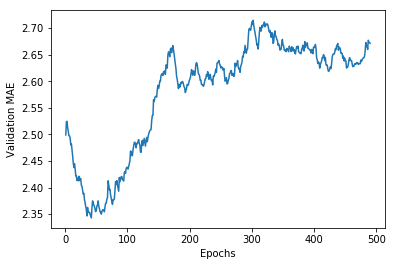

In [7]:
# making plot more readable
def smooth_curve(points, factor=.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [8]:
model = build_model()
model.fit(train_data, train_labels, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_labels)
test_mae_score

102/102 [==============================] - 0s 2ms/step


2.676421287013035

Final notes:
*   regression uses different loss functions, Mean Squared Error (MSE) 
*   same with metrics, mean absolute error (MAE) is common with regression
*   when features in the input data have values in different ranges, each feature should be scaled independently as a preproccessing step 
*   when little data is avaiable k-fold validaiton is a great way to reliably evalaute the model 
*   with little data it is common to use a small model to avoid overfitting 

Wrapping up on pg 91